# Independence Detection Trade-off Curves
### Information and Decision Systems Group<br>University of Chile

Implementation of the trade-off curves of independence detection presented by [Gonzalez et al. (2021)](https://arxiv.org/pdf/2110.14122.pdf). 

In [1]:
import sys
import time
import numpy as np
import pandas as pd
import multiprocessing as mp
import matplotlib.pyplot as plt
from itertools import repeat
sys.path.insert(1, '../src/build')
from TSP import TSP
sys.path.insert(1, './utils')
from distributions import *
from partition_tests import *

NUM_WORKERS = 4

In [2]:
# Utils
def tsp_experiment(iteration, tsp_params, dist, dist_params):
    l_bn, w_bn, lambdas = tsp_params
    dim, corr, n_samples = dist_params
    _, X, Y, _ = dist(dim, corr, n_samples)
    emis = []
    for l in lambdas:
        l_sizes = []
        l_emis = []
        tsp = TSP(l_bn, w_bn, l)
        for n in samples:
            tsp.grow(np.copy(X[:n], order='F'), np.copy(Y[:n], order='F'))
            if l != 0:
                tsp.regularize()
            l_emis.append(tsp.emi())
        emis.append(l_emis)
    return emis

def partition_test_experiment(iteration, test, dist, test_params, dist_params):
    p, C_values = test_params
    dim, corr, n_samples = dist_params
    _, X, Y, _ = dist(dim, corr, n_samples)
    sample_res = []
    for n in samples:
        m = int(n ** p)
        partition_test = test(n_partitions_x=m, n_partitions_y=m)
        test_results = []
        for C in C_values:
            partition_test.fit(X[:n], Y[:n])
            test_results.append(partition_test.strongly_consistent_test(C=C))
        sample_res.append(test_results)
    return sample_res

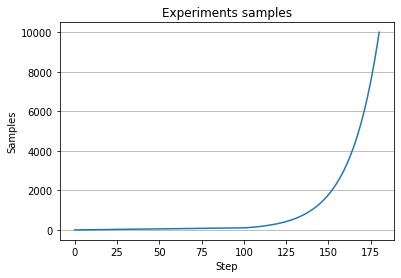

In [3]:
# Number of samples per step
samples = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 
                    26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 
                    49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 
                    72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 
                    95, 96, 97, 98, 99, 100, 101, 107, 114, 120, 127, 135, 143, 151, 160, 169, 179, 190, 201, 
                    213, 225, 239, 253, 268, 283, 300, 318, 336, 356, 377, 400, 423, 448, 475, 503, 532, 564, 
                    597, 632, 670, 709, 751, 796, 843, 893, 946, 1001, 1061, 1124, 1190, 1260, 1335, 1414, 1498,
                    1586, 1680, 1780, 1885, 1997, 2115, 2240, 2373, 2513, 2662, 2820, 2987, 3164, 3351, 3550, 
                    3760, 3983, 4218, 4468, 4733, 5013, 5310, 5625, 5958, 6311, 6685, 7081, 7500, 7945, 8415, 
                    8914, 9442, 10001])
step_to_samples = dict(zip(range(1, len(samples) + 1), samples))
n_samples = samples[-1]
plt.plot(samples)
plt.title('Experiments samples')
plt.xlabel('Step')
plt.ylabel('Samples')
plt.grid(axis='y')
plt.show()

## TSP Independence Test

In [4]:
# TSP parameters
l_bn = 0.001
w_bn = 0.1
lambdas = [1e-05, 1.38e-05, 1.75e-05, 2.13e-05, 2.5e-05, 3e-05, 3.5e-05, 4e-05, 4.5e-05, 5e-05, 
           7.5e-05, 0.0001, 0.00015, 0.0002, 0.00025, 0.0003, 0.00035, 0.0004, 0.00045, 0.0005]
# Experimental setting
dist = gaussian_dist
dim = 1
n_iterations = 1000
correlations = [0, 0.1, 0.3, 0.5, 0.7, 0.9]
# Experiments (parallelized)
results = []
for corr in correlations:
    tsp_params = [l_bn, w_bn, lambdas]
    dist_params = [dim, corr, n_samples]
    pool = mp.Pool(NUM_WORKERS)
    start_time = time.time()
    res = pool.starmap_async(tsp_experiment, list(zip(range(n_iterations), 
                                                      repeat(tsp_params), 
                                                      repeat(dist),
                                                      repeat(dist_params))))
    pool.close()
    pool.join()
    end_time = time.time()
    results.append(np.array(res.get()))
    print("Correlation: {:.1f} | Elapsed Time: {:.2f} [min]".format(corr, (end_time - start_time) / 60))

Correlation: 0.0 | Elapsed Time: 3.56 [min]
Correlation: 0.1 | Elapsed Time: 3.59 [min]
Correlation: 0.3 | Elapsed Time: 3.56 [min]
Correlation: 0.5 | Elapsed Time: 3.56 [min]
Correlation: 0.7 | Elapsed Time: 3.43 [min]
Correlation: 0.9 | Elapsed Time: 3.29 [min]


In [5]:
# Decreasing polynomial threshold
K = 0.5
p = 1.0
threshold = (K * samples ** -p)[:results[0].shape[-1]]

# Independence detection
results_table = [lambdas]
for l in range(len(correlations)):
    corr = correlations[l]
    data = results[l]
    results_corr = []
    for i in range(data.shape[1]):
        detection_times = []
        for k in range(data.shape[0]):
            # Decision rule
            if (corr > 0):
                phi = np.where(threshold < data[k,i,:], 0, 1)
            else:
                phi = np.where(threshold > data[k,i,:], 0, 1)
            # Detection time
            aux = np.cumsum(np.flip(phi))
            if (aux > 0).any():
                detec_time = data.shape[-1] - np.where(aux > 0)[0][0]
                detection_times += [detec_time]
            else:
                detection_times += [1]
        # Percentile 95 of detection time distribution
        results_corr.append(np.percentile(detection_times, 95, interpolation='higher'))
    results_table.append(results_corr)

# Step to samples
pd.set_option('display.float_format', '{:.7f}'.format)
df_tsp = pd.DataFrame(results_table)
df_tsp = df_tsp.transpose()
df_tsp[df_tsp.columns[1:]] = df_tsp[df_tsp.columns[1:]].applymap(np.int64)
df_tsp[df_tsp.columns[1:]] = df_tsp[df_tsp.columns[1:]].replace(step_to_samples)
df_tsp.columns = [r'$\alpha$', r'$\sigma=0.0$', r'$\sigma=0.1$', r'$\sigma=0.3$', 
                  r'$\sigma=0.5$', r'$\sigma=0.7$', r'$\sigma=0.9$']
df_tsp

,$\alpha$,$\sigma=0.0$,$\sigma=0.1$,$\sigma=0.3$,$\sigma=0.5$,$\sigma=0.7$,$\sigma=0.9$
0,0.0000100,10001,1586,76,22,13,5
1,0.0000138,8914,1885,76,22,13,5
2,0.0000175,7081,2115,78,22,13,5
3,0.0000213,5625,2513,79,22,13,5
4,0.0000250,3983,3164,89,22,13,5
5,0.0000300,2820,3983,93,22,13,5
6,0.0000350,2240,5310,98,23,13,5
7,0.0000400,1997,6311,127,31,13,5
8,0.0000450,1498,7945,143,31,13,5
9,0.0000500,1190,8914,179,38,13,5


## $L_1$ Independence Test

In [6]:
# Test parameters
test = L1Test
p = 0.2
C_L1 = [1.2, 1.175, 1.15, 1.125, 1.1, 1.05, 1.0, 0.95, 0.9, 0.875, 
        0.85, 0.8, 0.775, 0.75, 0.7, 0.675]
# Experimental setting
dist = gaussian_dist
dim = 1
n_iterations = 1000
correlations = [0, 0.1, 0.3, 0.5, 0.7, 0.9]
# Experiments (parallelized)
results = []
for corr in correlations:
    test_params = [p, C_L1]
    dist_params = [dim, corr, n_samples]
    pool = mp.Pool(NUM_WORKERS)
    start_time = time.time()
    res = pool.starmap_async(partition_test_experiment, list(zip(range(n_iterations),
                                                                 repeat(test),
                                                                 repeat(dist),
                                                                 repeat(test_params),
                                                                 repeat(dist_params))))
    pool.close()
    pool.join()
    end_time = time.time()
    results.append(np.array(res.get()))
    print("Correlation: {:.1f} | Elapsed Time: {:.2f} [min]".format(corr, (end_time - start_time) / 60))

Correlation: 0.0 | Elapsed Time: 7.43 [min]
Correlation: 0.1 | Elapsed Time: 7.46 [min]
Correlation: 0.3 | Elapsed Time: 7.59 [min]
Correlation: 0.5 | Elapsed Time: 7.12 [min]
Correlation: 0.7 | Elapsed Time: 7.07 [min]
Correlation: 0.9 | Elapsed Time: 7.10 [min]


In [8]:
# Independence detection
results_table = [C_L1]
for l in range(len(correlations)):
    corr = correlations[l]
    data = results[l]
    results_corr = []
    for i in range(data.shape[2]):
        detection_times = []
        for k in range(data.shape[0]):
            # Decision rule
            if (corr > 0):
                phi = np.where(data[k,:,i] <= 0, 0, 1)
            else:
                phi = np.where(data[k,:,i] > 0, 0, 1)
            # Detection time
            aux = np.cumsum(np.flip(phi))
            if (aux > 0).any():
                detec_time = data.shape[1] - np.where(aux > 0)[0][0]
                detection_times += [detec_time]
            else:
                detection_times += [1]
        # Percentile 95 of detection time distribution
        results_corr.append(np.percentile(detection_times, 95, interpolation='higher'))
    results_table.append(results_corr)
    
# Step to samples
pd.set_option('display.float_format', '{:.7f}'.format)
df_L1 = pd.DataFrame(results_table)
df_L1 = df_L1.transpose()
df_L1[df_L1.columns[1:]] = df_L1[df_L1.columns[1:]].applymap(np.int64)
df_L1[df_L1.columns[1:]] = df_L1[df_L1.columns[1:]].replace(step_to_samples)
df_L1.columns = ['C', r'$\rho=0.0$', r'$\rho=0.1$', r'$\rho=0.3$', 
                 r'$\rho=0.5$', r'$\rho=0.7$', r'$\rho=0.9$']
df_L1

,C,$\rho=0.0$,$\rho=0.1$,$\rho=0.3$,$\rho=0.5$,$\rho=0.7$,$\rho=0.9$
0,1.2000000,1,10001,1061,268,86,37
1,1.1750000,32,10001,1061,253,85,36
2,1.1500000,32,10001,946,239,80,36
3,1.1250000,56,10001,843,239,79,35
4,1.1000000,63,10001,796,225,79,35
5,1.0500000,101,10001,709,179,73,34
6,1.0000000,114,10001,632,160,67,33
7,0.9500000,169,10001,564,151,66,32
8,0.9000000,300,8914,532,135,65,31
9,0.8750000,946,8415,475,135,64,31


## Log-likelihood Independence Test

In [9]:
# Test parameters
test = LogLikelihoodTest
p = 0.2
C_like = [0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.125, 0.15, 0.175, 
          0.2, 0.21, 0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.3]
# Experimental setting
dist = gaussian_dist
dim = 1
n_iterations = 1000
correlations = [0, 0.1, 0.3, 0.5, 0.7, 0.9]
# Experiments (parallelized)
results = []
for corr in correlations:
    test_params = [p, C_like]
    dist_params = [dim, corr, n_samples]
    pool = mp.Pool(NUM_WORKERS)
    start_time = time.time()
    res = pool.starmap_async(partition_test_experiment, list(zip(range(n_iterations),
                                                                 repeat(test),
                                                                 repeat(dist),
                                                                 repeat(test_params),
                                                                 repeat(dist_params))))
    pool.close()
    pool.join()
    end_time = time.time()
    results.append(np.array(res.get()))
    print("Correlation: {:.1f} | Elapsed Time: {:.2f} [min]".format(corr, (end_time - start_time) / 60))

Correlation: 0.0 | Elapsed Time: 7.86 [min]
Correlation: 0.1 | Elapsed Time: 8.12 [min]
Correlation: 0.3 | Elapsed Time: 7.95 [min]
Correlation: 0.5 | Elapsed Time: 7.99 [min]
Correlation: 0.7 | Elapsed Time: 7.98 [min]
Correlation: 0.9 | Elapsed Time: 7.92 [min]


In [10]:
# Independence detection
results_table = [C_like]
for l in range(len(correlations)):
    corr = correlations[l]
    data = results[l]
    results_corr = []
    for i in range(data.shape[2]):
        detection_times = []
        for k in range(data.shape[0]):
            # Decision rule
            if (corr > 0):
                phi = np.where(data[k,:,i] <= 0, 0, 1)
            else:
                phi = np.where(data[k,:,i] > 0, 0, 1)
            # Detection time
            aux = np.cumsum(np.flip(phi))
            if (aux > 0).any():
                detec_time = data.shape[1] - np.where(aux > 0)[0][0]
                detection_times += [detec_time]
            else:
                detection_times += [1]
        # Percentile 95 of detection time distribution
        results_corr.append(np.percentile(detection_times, 95, interpolation='higher'))
    results_table.append(results_corr)
    
# Step to samples
pd.set_option('display.float_format', '{:.7f}'.format)
df_like = pd.DataFrame(results_table)
df_like = df_like.transpose()
df_like[df_like.columns[1:]] = df_like[df_like.columns[1:]].applymap(np.int64)
df_like[df_like.columns[1:]] = df_like[df_like.columns[1:]].replace(step_to_samples)
df_like.columns = ['C', r'$\rho=0.0$', r'$\rho=0.1$', r'$\rho=0.3$', 
                   r'$\rho=0.5$', r'$\rho=0.7$', r'$\rho=0.9$']
df_like

,C,$\rho=0.0$,$\rho=0.1$,$\rho=0.3$,$\rho=0.5$,$\rho=0.7$,$\rho=0.9$
0,0.0500000,10001,1885,239,96,39,31
1,0.0600000,10001,2373,239,97,39,31
2,0.0700000,9442,2820,239,107,40,31
3,0.0800000,7500,3550,239,107,44,31
4,0.0900000,5625,4218,253,114,46,31
5,0.1000000,2662,4468,300,114,47,31
6,0.1250000,1001,7945,377,135,58,31
7,0.1500000,253,9442,448,151,64,31
8,0.1750000,151,10001,503,160,66,31
9,0.2000000,88,10001,564,179,72,32


## Pearson-$\chi^2$ Independence Test

In [11]:
# Test parameters
test = PearsonChiSquareTest
p = 0.25
C_pearson = [0.14, 0.1375, 0.135, 0.13, 0.125, 0.12, 0.115, 
             0.11, 0.1, 0.095, 0.09, 0.08, 0.07, 0.06, 0.05]
# Experimental setting
dist = gaussian_dist
dim = 1
n_iterations = 1000
correlations = [0, 0.1, 0.3, 0.5, 0.7, 0.9]
# Experiments (parallelized)
results = []
for corr in correlations:
    test_params = [p, C_pearson]
    dist_params = [dim, corr, n_samples]
    pool = mp.Pool(NUM_WORKERS)
    start_time = time.time()
    res = pool.starmap_async(partition_test_experiment, list(zip(range(n_iterations),
                                                                 repeat(test),
                                                                 repeat(dist),
                                                                 repeat(test_params),
                                                                 repeat(dist_params))))
    pool.close()
    pool.join()
    end_time = time.time()
    results.append(np.array(res.get()))
    print("Correlation: {:.1f} | Elapsed Time: {:.2f} [min]".format(corr, (end_time - start_time) / 60))

../utils/partition_tests.py:124: RuntimeWarning: divide by zero encountered in double_scalars
  (self.n_data * np.log((self.n_partitions_x ** self.dx) * (self.n_partitions_y ** self.dy)))) ** 2
../utils/partition_tests.py:124: RuntimeWarning: divide by zero encountered in double_scalars
  (self.n_data * np.log((self.n_partitions_x ** self.dx) * (self.n_partitions_y ** self.dy)))) ** 2
../utils/partition_tests.py:124: RuntimeWarning: divide by zero encountered in double_scalars
  (self.n_data * np.log((self.n_partitions_x ** self.dx) * (self.n_partitions_y ** self.dy)))) ** 2
../utils/partition_tests.py:124: RuntimeWarning: divide by zero encountered in double_scalars
  (self.n_data * np.log((self.n_partitions_x ** self.dx) * (self.n_partitions_y ** self.dy)))) ** 2


Correlation: 0.0 | Elapsed Time: 10.97 [min]


../utils/partition_tests.py:124: RuntimeWarning: divide by zero encountered in double_scalars
  (self.n_data * np.log((self.n_partitions_x ** self.dx) * (self.n_partitions_y ** self.dy)))) ** 2
../utils/partition_tests.py:124: RuntimeWarning: divide by zero encountered in double_scalars
  (self.n_data * np.log((self.n_partitions_x ** self.dx) * (self.n_partitions_y ** self.dy)))) ** 2
../utils/partition_tests.py:124: RuntimeWarning: divide by zero encountered in double_scalars
  (self.n_data * np.log((self.n_partitions_x ** self.dx) * (self.n_partitions_y ** self.dy)))) ** 2
../utils/partition_tests.py:124: RuntimeWarning: divide by zero encountered in double_scalars
  (self.n_data * np.log((self.n_partitions_x ** self.dx) * (self.n_partitions_y ** self.dy)))) ** 2


Correlation: 0.1 | Elapsed Time: 10.93 [min]


../utils/partition_tests.py:124: RuntimeWarning: divide by zero encountered in double_scalars
  (self.n_data * np.log((self.n_partitions_x ** self.dx) * (self.n_partitions_y ** self.dy)))) ** 2
../utils/partition_tests.py:124: RuntimeWarning: divide by zero encountered in double_scalars
  (self.n_data * np.log((self.n_partitions_x ** self.dx) * (self.n_partitions_y ** self.dy)))) ** 2
../utils/partition_tests.py:124: RuntimeWarning: divide by zero encountered in double_scalars
  (self.n_data * np.log((self.n_partitions_x ** self.dx) * (self.n_partitions_y ** self.dy)))) ** 2
../utils/partition_tests.py:124: RuntimeWarning: divide by zero encountered in double_scalars
  (self.n_data * np.log((self.n_partitions_x ** self.dx) * (self.n_partitions_y ** self.dy)))) ** 2


Correlation: 0.3 | Elapsed Time: 10.90 [min]


../utils/partition_tests.py:124: RuntimeWarning: divide by zero encountered in double_scalars
  (self.n_data * np.log((self.n_partitions_x ** self.dx) * (self.n_partitions_y ** self.dy)))) ** 2
../utils/partition_tests.py:124: RuntimeWarning: divide by zero encountered in double_scalars
  (self.n_data * np.log((self.n_partitions_x ** self.dx) * (self.n_partitions_y ** self.dy)))) ** 2
../utils/partition_tests.py:124: RuntimeWarning: divide by zero encountered in double_scalars
  (self.n_data * np.log((self.n_partitions_x ** self.dx) * (self.n_partitions_y ** self.dy)))) ** 2
../utils/partition_tests.py:124: RuntimeWarning: divide by zero encountered in double_scalars
  (self.n_data * np.log((self.n_partitions_x ** self.dx) * (self.n_partitions_y ** self.dy)))) ** 2


Correlation: 0.5 | Elapsed Time: 11.29 [min]


../utils/partition_tests.py:124: RuntimeWarning: divide by zero encountered in double_scalars
  (self.n_data * np.log((self.n_partitions_x ** self.dx) * (self.n_partitions_y ** self.dy)))) ** 2
../utils/partition_tests.py:124: RuntimeWarning: divide by zero encountered in double_scalars
  (self.n_data * np.log((self.n_partitions_x ** self.dx) * (self.n_partitions_y ** self.dy)))) ** 2
../utils/partition_tests.py:124: RuntimeWarning: divide by zero encountered in double_scalars
  (self.n_data * np.log((self.n_partitions_x ** self.dx) * (self.n_partitions_y ** self.dy)))) ** 2
../utils/partition_tests.py:124: RuntimeWarning: divide by zero encountered in double_scalars
  (self.n_data * np.log((self.n_partitions_x ** self.dx) * (self.n_partitions_y ** self.dy)))) ** 2


Correlation: 0.7 | Elapsed Time: 10.95 [min]


../utils/partition_tests.py:124: RuntimeWarning: divide by zero encountered in double_scalars
  (self.n_data * np.log((self.n_partitions_x ** self.dx) * (self.n_partitions_y ** self.dy)))) ** 2
../utils/partition_tests.py:124: RuntimeWarning: divide by zero encountered in double_scalars
  (self.n_data * np.log((self.n_partitions_x ** self.dx) * (self.n_partitions_y ** self.dy)))) ** 2
../utils/partition_tests.py:124: RuntimeWarning: divide by zero encountered in double_scalars
  (self.n_data * np.log((self.n_partitions_x ** self.dx) * (self.n_partitions_y ** self.dy)))) ** 2
../utils/partition_tests.py:124: RuntimeWarning: divide by zero encountered in double_scalars
  (self.n_data * np.log((self.n_partitions_x ** self.dx) * (self.n_partitions_y ** self.dy)))) ** 2


Correlation: 0.9 | Elapsed Time: 11.03 [min]


In [12]:
# Independence detection
results_table = [C_pearson]
for l in range(len(correlations)):
    corr = correlations[l]
    data = results[l]
    results_corr = []
    for i in range(data.shape[2]):
        detection_times = []
        for k in range(data.shape[0]):
            # Decision rule
            if (corr > 0):
                phi = np.where(data[k,:,i] <= 0, 0, 1)
            else:
                phi = np.where(data[k,:,i] > 0, 0, 1)
            # Detection time
            aux = np.cumsum(np.flip(phi))
            if (aux > 0).any():
                detec_time = data.shape[1] - np.where(aux > 0)[0][0]
                detection_times += [detec_time]
            else:
                detection_times += [1]
        # Percentile 95 of detection time distribution
        results_corr.append(np.percentile(detection_times, 95, interpolation='higher'))
    results_table.append(results_corr)
    
# Step to samples
pd.set_option('display.float_format', '{:.7f}'.format)
df_pearson = pd.DataFrame(results_table)
df_pearson = df_pearson.transpose()
df_pearson[df_pearson.columns[1:]] = df_pearson[df_pearson.columns[1:]].applymap(np.int64)
df_pearson[df_pearson.columns[1:]] = df_pearson[df_pearson.columns[1:]].replace(step_to_samples)
df_pearson.columns = ['C', r'$\rho=0.0$', r'$\rho=0.1$', r'$\rho=0.3$', 
                   r'$\rho=0.5$', r'$\rho=0.7$', r'$\rho=0.9$']
df_pearson

,C,$\rho=0.0$,$\rho=0.1$,$\rho=0.3$,$\rho=0.5$,$\rho=0.7$,$\rho=0.9$
0,0.1400000,1,10001,1335,300,107,45
1,0.1375000,1,10001,1335,283,107,44
2,0.1350000,50,10001,1335,283,107,44
3,0.1300000,79,10001,946,268,107,44
4,0.1250000,79,10001,893,268,101,42
5,0.1200000,80,10001,843,268,100,42
6,0.1150000,160,10001,796,268,100,38
7,0.1100000,253,10001,796,179,97,38
8,0.1000000,400,10001,751,151,94,37
9,0.0950000,597,10001,709,143,91,36


## Independence Detection Trade-off Curves

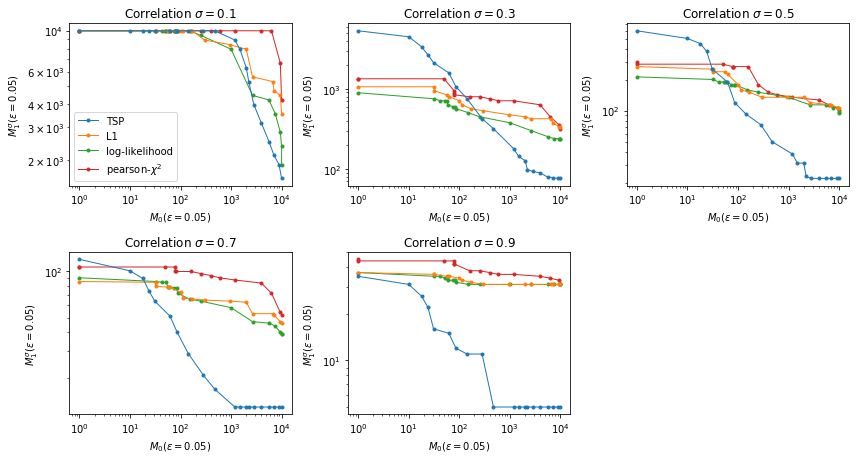

In [13]:
rhos = [0.1, 0.3, 0.5, 0.7, 0.9]
tabs = [df_tsp, df_L1, df_like, df_pearson]
names = ['TSP', 'L1', 'log-likelihood', r'pearson-$\chi^2$']
plt.figure(figsize=(12,6.5))
for j in range(len(rhos)):
    plt.subplot(2, 3, j+1)
    for i in range(len(tabs)):
        plt.plot(tabs[i][tabs[i].columns[1]].to_numpy(), 
                 tabs[i][tabs[i].columns[j+2]].to_numpy(),
                 '.-', label=names[i], zorder=len(tabs)-i, ms=6, linewidth=1)
    plt.xlabel(r'$M_0(\epsilon =0.05)$')
    plt.ylabel(r'$M^\sigma_1(\epsilon =0.05)$'.format(rhos[j]))
    plt.title(r'Correlation $\sigma={}$'.format(rhos[j]))
    plt.xscale('log')
    plt.yscale('log')
    if j == 0:
        plt.legend()
plt.tight_layout()
plt.show()